# Analyzing CIA Factbook Data
In this project I will work with [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/) data which contains demographic information about different countries in the world. The data is stored in a database, which can be cloned from a [public repository](https://github.com/factbook/factbook.sql/releases). SQL will be used to interface with the database to do some preliminary EDA by querying data relevant to various questions of interest.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

conn = sqlite3.connect('factbook.db')
cursor = conn.cursor()

In [2]:
# return information on the tables in the database
q = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [3]:
cursor.execute(q).fetchall()

[('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)'),
 ('table',
  'facts',
  'facts',
  47,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float)')]

In [4]:
# returns the first 5 rows of the facts table in the database
q2 = "SELECT * FROM facts LIMIT 5"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [5]:
# returns min population, max population, minimum population growth, maximum population growth
q3 = '''
SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth)
FROM facts
'''

pd.read_sql_query(q3, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


Let's investigate the outlier countries which have a population of 0, or a population of 7256490011 since these values seem unrealistic.

In [6]:
q4 = '''
SELECT *
FROM facts
WHERE population = 0
'''

pd.read_sql_query(q4, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [7]:
q5 = '''
SELECT *
FROM facts
WHERE population = 7256490011
'''

pd.read_sql_query(q5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


It seems that Antarctica has a population of 0.
The 'World' row has a population of 7256490011, which appears to be accurate.

We can exclude these two extreme cases, and generate histograms for different country metrics.

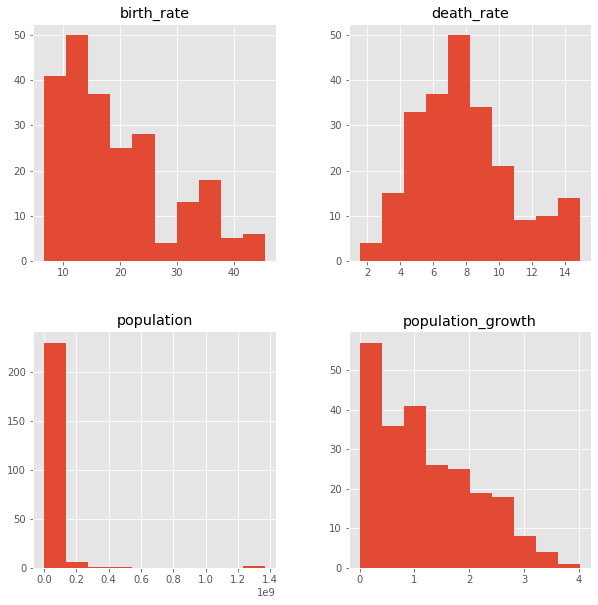

In [8]:
# Query excluding two Oulier rows above
q6 = '''
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE name <> "Antarctica" 
AND name <> "World";
'''

hist_df = pd.read_sql_query(q6, conn)

style.use('ggplot')

# Generate Histogram
hist_df.hist(figsize=(10,10))
plt.show()

In [9]:
# Which countries have the highest population density
q7 = '''
SELECT name, CAST(population AS FLOAT) / CAST(area AS FLOAT) AS pop_density
FROM facts
ORDER BY pop_density DESC
LIMIT 25
'''
pd.read_sql_query(q7, conn)

,name,pop_density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


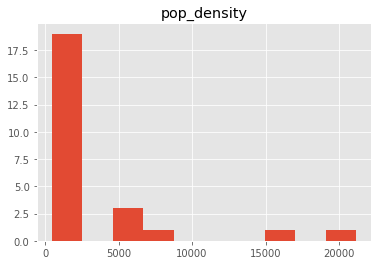

In [10]:
pd.read_sql_query(q7, conn).hist()
plt.show()

In [11]:
# Which countries have the highest ratios of water to land
q8 = '''
SELECT name, CAST(area_water AS FLOAT) / CAST(area_land AS FLOAT) AS water_land_ratio
FROM facts
ORDER BY water_land_ratio DESC
LIMIT 25
'''
pd.read_sql_query(q8, conn)

,name,water_land_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


In [12]:
# Which countries have more water than land?
q8 = '''
SELECT name, CAST(area_water AS FLOAT) / CAST(area_land AS FLOAT) AS water_land_ratio
FROM facts
WHERE water_land_ratio > 1.0
ORDER BY water_land_ratio DESC
'''
pd.read_sql_query(q8, conn)

,name,water_land_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
